In [70]:
import utils.lib_feature_proc as myproc
import utils.action_classifier as myclf
import utils.lib_plot as mydisp
import importlib

In [71]:
import pandas as pd
import simplejson
import numpy as np
import math
import sklearn
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import simplejson
RAND_SEED = 1

In [72]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [73]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [74]:
# load data
def encode_Y(Y_str):
    ''' Encode string labels into index label and one-hot label.
    Arguments:
        Y_str     {list of str}:     Label of each image.
    Returns:
        classes   {list of string}:  e.g. Three types of actions: ["run", "sit", "walk"] 
        Y_indices {list of int}:     Label index of each image, e.g. [0,2,0,...]
        Y_one_hot {list of list}:    One-hot encoding of each image. For example:
            The indices [0,2,0,...] are converted to [[1,0,0], [0,0,1], [1,0,0], ...]
    '''
    # One-hot encoder. e.g: Y_one_hot = [1,0,0,0], [0,1,0,0], ...
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(Y_str)
    classes = enc.categories_[0]
    Y_one_hot = enc.transform(Y_str).toarray()
    
    # Get label index. e.g: Y = 0, 1, 2, ...
    Y_indices = [np.where(yi == 1)[0][0] for yi in Y_one_hot]
    return classes, Y_indices, Y_one_hot

def get_valid_skeleton_indices(X0, NaN=0):
    ''' A valid skeleton X0[i] has no NaN in the upper body joints. 
    '''
    left, right = 0, 14*2 # Only check 14 data, which are: 1head+1neck+2*(3arms + 3legs)
    def is_valid(x):
        return len(np.where(x[left:right] == NaN)[0]) == 0
    valid_indices = [for i, x in enumerate(X0) if is_valid(x)]
    return valid_indices


def load_my_data(filepath):
    ''' Load training data.
    Suppose there are N valid data, and K classes.
    Arguments:
        filepath {str}: file path of skeletons_info.txt which stores the skeletons and labels.
    Returns:
        X: skeleton of each valid image
        Y: label of each valid image
        video_indices: the video index of which the image belongs to
        classes: The classes of all actions
    '''
    with open(filepath, 'r') as f:
        # Load data
        dataset = simplejson.load(f)
        
        # Remove bad data. A bad data is filled with zeros.
        def is_good_data(row):
            return row[0] != 0
        dataset = [row for i, row in enumerate(dataset) if is_good_data(row)]
        
        # Get skeleton data, which is in [5, 41)
        X = np.array([row[5:5+36] for row in dataset])

        # row[1] is the video index of the image
        video_indices = [row[1] for row in dataset]
        
        # row[3] is the label of the image
        Y_str = [[row[3]] for row in dataset]
        
        classes, Y, Y_one_hot = encode_Y(Y_str)
        print("Num samples = ", len(Y))
        
        if 0:
            valid_indices = get_valid_skeleton_indices(X, NaN=0)
            X = X[valid_indices, :]
            Y = [Y[i] for i in valid_indices]
            video_indices = [video_indices[i] for i in valid_indices]
            print("Num samples after removal = ", len(Y))
        
        return X, Y, video_indices, classes
    print("my Error: loading skeletons_info.txt failed.")
    return None, None

def split_data(X, Y):
    if 1:
        tr_X, te_X, tr_Y, te_Y = train_test_split(X, Y, test_size=0.3, random_state=RAND_SEED)
    else:
        tr_X = np.copy(X)
        tr_Y = Y.copy()
        te_X = np.copy(X)
        te_Y = Y.copy()
    print("Size of X:", tr_X.shape)
    print("Num training: ", len(tr_Y))
    print("Num testing:  ", len(te_Y))
    return tr_X, te_X, tr_Y, te_Y

In [75]:
# Process features
def extract_time_serials_data(X, Y, video_indices, is_adding_noise):
    X_new = []
    Y_new = []

    # Loop through all data
    for i, _ in enumerate(video_indices):

        # If a new video clip starts, reset the feature generator
        if i == 0 or video_indices[i] != video_indices[i-1]:
            fg = myproc.FeatureGenerator(is_adding_noise)
        
        # Get features
        success, features = fg.add_curr_skeleton(X[i,:])
        if success: # True if (data length > 5) and (skeleton has enough joints) 
            X_new.append(features)
            Y_new.append(Y[i])

    X_new = np.array(X_new)
    return X_new, Y_new

In [76]:
X0, Y0, video_indices, classes = load_my_data('skeleton_data/skeletons5_info.txt')

labels:  ['jump' 'kick' 'punch' 'run' 'sit' 'squat' 'stand' 'walk' 'wave']
Num samples =  11202


In [77]:
# Get time serials data
importlib.reload(myproc)
X1, Y1 = extract_time_serials_data(X0, Y0, video_indices, is_adding_noise=True)
X2, Y2 = extract_time_serials_data(X0, Y0, video_indices, is_adding_noise=False)
X = np.vstack((X1, X2))
Y = np.concatenate((Y1, Y2))
print("After extract time serials:", "X.shape = ", X.shape, ", len(Y) = ", len(Y))
tr_X, te_X, tr_Y, te_Y = split_data(X, Y)

After extract time serials: X.shape =  (21748, 314) , len(Y) =  21748
Size of X: (15223, 314)
Num training:  15223
Num testing:   6525


In [78]:
importlib.reload(myclf)
model = myclf.ClassifierOfflineTrain()
model.train(tr_X, tr_Y)

Sum eig values: 0.9847015021053008
After PCA, X.shape =  (15223, 80)


Accuracy is  1.0
Accuracy is  0.9903448275862069
Time cost for predicting one sample: 9.32039266477202e-06
Confusion matrix, without normalization


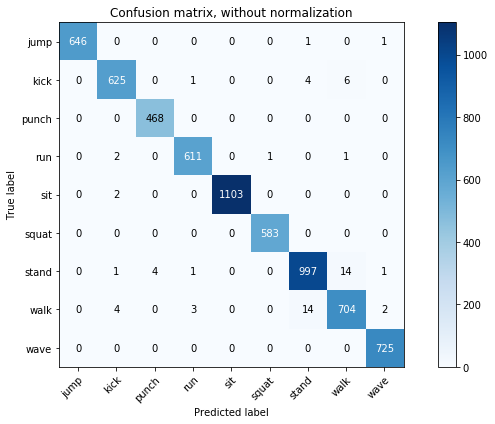

In [79]:
importlib.reload(mydisp)
import time

t0 = time.time()

tr_accu, tr_Y_predict = model.predict_and_evaluate(tr_X, tr_Y)
te_accu, te_Y_predict = model.predict_and_evaluate(te_X, te_Y)

print( "Time cost for predicting one sample:", (time.time() - t0) / len(Y) )

# axis, cf = mydisp.plot_confusion_matrix(tr_Y, tr_Y_predict, classes, normalize=True)
axis, cf = mydisp.plot_confusion_matrix(te_Y, te_Y_predict, classes, normalize=False, size=(10, 6))

In [80]:
from sklearn.metrics import classification_report
print(classification_report(te_Y, te_Y_predict, target_names=classes))

              precision    recall  f1-score   support

        jump       1.00      1.00      1.00       648
        kick       0.99      0.98      0.98       636
       punch       0.99      1.00      1.00       468
         run       0.99      0.99      0.99       615
         sit       1.00      1.00      1.00      1105
       squat       1.00      1.00      1.00       583
       stand       0.98      0.98      0.98      1018
        walk       0.97      0.97      0.97       727
        wave       0.99      1.00      1.00       725

    accuracy                           0.99      6525
   macro avg       0.99      0.99      0.99      6525
weighted avg       0.99      0.99      0.99      6525



In [81]:
if 0 and model.model_name=="Neural Net":
    
    # Save trained model to file
    import pickle
    path_to_save_model = '../model/trained_classifier.pickle'
    
    with open(path_to_save_model, 'wb') as f:
        pickle.dump(model, f)

    if 1:
        # Load and test again to ensure correctly saved to file
        with open(path_to_save_model, 'rb') as f:
            model2 = pickle.load(f)
        print(tr_X.shape)
        model2.predict_and_evaluate(tr_X, tr_Y)
        model2.predict_and_evaluate(te_X, te_Y)
        print("OK, model is saved to disk. I can test it on webcam")

(15223, 314)
Accuracy is  1.0
Accuracy is  0.9903448275862069
OK, model is saved to disk. I can test it on webcam
